In [76]:
import numpy as np
import heartpy as hp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
import sys
from datetime import datetime
# Automatic Gain Control=Checked,IR PA (mA)=10,Red PA (mA)=10,IR LED Range (mA)=51,Red LED Range (mA)=51,ALC + FDM=Checked,
# Sample Rate (Hz)=100,Pulse Width (usec)=400,ADC Range (nA)=32768,FIFO Rolls on Full=Checked,FIFO Almost Full=17,Sample 
# Averaging=1,IA Gain=5,ECG Gain=8,Sample Rate=200,Adaptive Filter=Checked,Notch Freq=60,Cutoff Freq=50,

In [103]:
### Peak Finding Parameters ###
MIN_WIDTH = 10
MAX_WIDTH = 500
PROMINENCE_IR = 1000
PROMINENCE_RED = 500
HEIGHT = None
THRESHOLD = None

### SpO2 Parameters ###
a = -16.666666 # SpO2 = aR^2 + bR + c
b = 8.333333
c = 100

In [102]:
def convert_to_sec(t):
    """This function converts the string in format yyyy-mm-dd hh:mm:ss:SSS to a float
    with the format ss:SSS. Only converts from minutes down to seconds. Not for >= 1 hr
    long data.

    Args:
        t (str): datetime string with format yyyy-mm-dd hh:mm:ss:SSS

    Returns:
        total (float): seconds calculated from mm:ss.SSS
    """
    t = t[14:]
    min = float(t[:t.find(":")])
    sec = float(t[t.find(":")+1:])
    total = (min*60)+sec
    return total

def smooth_data(dataset, analysis_type):
    """Takes in a dataset and smoothes the data for
    analysis.

    Args:
        dataset (DataFrame): a dataframe containing the necessary data
        analysis_type (string): what data to smooth down

    Returns:
        Array: the filtered signal
    """
    #read in data
    if analysis_type.lower() == 'ir':
        signal = dataset[' IR Count']
    elif analysis_type.lower() == 'red':
        signal = dataset[' Red Count']
    else:
        sys.exit("Wrong input for analysis_type. Accepted values are 'ir' or 'red'.")
    
    
    time = dataset['Time']

    #get sample rate
    sample_rate = hp.get_samplerate_datetime(time, timeformat = '%Y-%m-%d %H:%M:%S.%f')
    #print('sampling rate is: %.3f Hz' %sample_rate)

    #find seconds elapsed (ALL OF THIS TIME STUFF IS FOR THE PLOT SO WE DON'T REALLY NEED IT! It might be a faster way to do convert_to_sec though!)
    start = datetime.strptime(time[0], '%Y-%m-%d %H:%M:%S.%f')
    start_timedelta = start - datetime(1900, 1, 1)
    start_seconds = start_timedelta.total_seconds()

    end = datetime.strptime(time[time.index[-1]], '%Y-%m-%d %H:%M:%S.%f')
    end_timedelta = end - datetime(1900, 1, 1)
    end_seconds = end_timedelta.total_seconds()

    total_time = end_seconds - start_seconds
    print(f'Time elapsed: {total_time} s')

    #filter signal using bandpass
    filtered = hp.filter_signal(signal, [0.5, 4], sample_rate=sample_rate, order=3, filtertype='bandpass')
    
    #demonstrate effectiveness
    plt.figure(figsize=(12,8))
    plt.subplot(211)
    plt.plot(signal[0:int(total_time * sample_rate)])
    plt.title(f'Original {analysis_type} data')
    plt.subplot(212)
    plt.plot(filtered[0:int(total_time * sample_rate)])
    plt.title(f'Filtered {analysis_type} data')
    plt.show()

    print(f'Results from turning original {analysis_type} count signal of length {len(signal)} into filtered IR count signal of {len(filtered)}')
    print(f"This function does not add the filtered time signal into any dataset though, we'll probably work on that later")
    return filtered

def peak_valley_finder_and_plot(data, time, prominence):
    """finds the peaks of a dataset and plots the data

    Args:
        data (list/list-like): the y-axis values of the dataset
        time (list/list-like): the x-axis time values of the dataset (should be same shape as data) 

    Returns:
        list: list containing the indexes of all of the peaks in the dataset (no minimum peaks, just maxes)
    """
    peaks = find_peaks(data, height=HEIGHT, threshold=THRESHOLD, prominence=prominence, width=(MIN_WIDTH, MAX_WIDTH))[0]
    valleys = find_peaks(-data, height=HEIGHT, threshold=THRESHOLD, prominence=prominence, width=(MIN_WIDTH, MAX_WIDTH))[0]
    
    # fixes edge case where max of a peak/valley is found twice in same peak.
    usedValues_peaks = set()
    newList = []
    for v in peaks:
        if v not in usedValues_peaks:
            newList.append(v)
            for lv in range(v - MIN_WIDTH, v + MIN_WIDTH + 1):
                usedValues_peaks.add(lv)
    peaks = list(newList)
    
    usedValues_valleys = set()
    newList2 = []
    for v in valleys:
        if v not in usedValues_valleys:
            newList2.append(v)
            for lv in range(v - MIN_WIDTH, v + MIN_WIDTH + 1):
                usedValues_valleys.add(lv)
    valleys = list(newList2)
    
    #plotting
    plt.figure(figsize=(12,4))
    plt.plot(time, data, label = "Signal")
    plt.plot(time[peaks], data[peaks], "x", label = "peaks")
    plt.plot(time[valleys], data[valleys], "x", label="valleys")
    plt.xlabel("Time (s)")
    plt.ylabel("Signal Count")
    plt.title("Signal Count vs Time")
    plt.legend()
    plt.show()
    return peaks, valleys

def avg_peak_and_trough_vals(red_count, ir_count, red_peak_loc, red_val_loc, ir_peak_loc, ir_val_loc):
    red_peak_vals = red_count[red_peak_loc]
    red_val_vals = red_count[red_val_loc]
    ir_peak_vals = ir_count[ir_peak_loc]
    ir_val_vals = ir_count[ir_val_loc]
    
    avg_red_peak = np.mean(red_peak_vals)
    avg_red_val = np.mean(red_val_vals)
    avg_ir_peak = np.mean(ir_peak_vals)
    avg_ir_val = np.mean(ir_val_vals)
    
    avg_AC_red = np.mean(red_peak_vals)  - np.mean(red_val_vals)
    avg_DC_red = np.mean(red_val_vals)
    
    avg_AC_ir = np.mean(ir_peak_vals) - np.mean(ir_val_vals)
    avg_DC_ir = np.mean(ir_val_vals)
    
    avg_R = (avg_AC_red/avg_DC_red)/(avg_AC_ir/avg_DC_ir)
    
    avg_SpO2 = a*avg_R**2 + b*avg_R + c
    
    return avg_red_peak, avg_red_val, avg_ir_peak, avg_ir_val, avg_R, avg_SpO2

In [118]:
# CSV # 1
#df = pd.read_csv("C:\data\honors project ppg data\ECPPG_2023-10-21_21-29-57.csv") #Karston
#df = pd.read_csv("C:\\Users\pazul\Documents\BMEN 207\Honors Project\Coding\data\ECPPG_2023-10-21_21-29-57.csv") #Pablo

# CSV # 2
#df = pd.read_csv("C:\\Users\pazul\Documents\BMEN 207\Honors Project\Coding\data\ECPPG_2023-10-21_23-45-37.csv") # Pablo

# CSV # 3
#df = pd.read_csv("C:\\Users\pazul\Documents\BMEN 207\Honors Project\Coding\data\ECPPG_2023-10-21.csv") # Pablo

# CSV # 4
df = pd.read_csv("C:\\Users\pazul\Documents\BMEN 207\Honors Project\Coding\data\ECPPG_2023-11-07_12-17-55.csv") # Pablo
df.drop(df.head(2750).index, axis=0, inplace=True)
df.drop(df.tail(2750).index, axis=0, inplace=True)
df.reset_index(inplace=True)
df.head

<bound method NDFrame.head of        index                     Time   Sample Count   IR Count   Red Count  \
0       2750  2023-11-07 12:18:29.697           2801     235549      221018   
1       2751  2023-11-07 12:18:29.697           2802     235552      221014   
2       2752  2023-11-07 12:18:29.697           2803     235570      221013   
3       2753  2023-11-07 12:18:29.732           2804     235561      221017   
4       2754  2023-11-07 12:18:29.732           2805     235564      220996   
...      ...                      ...            ...        ...         ...   
11801  14551  2023-11-07 12:19:28.713          14602     236146      216905   
11802  14552  2023-11-07 12:19:28.713          14603     236167      216903   
11803  14553  2023-11-07 12:19:28.713          14604     236169      216896   
11804  14554  2023-11-07 12:19:28.713          14605     236179      216897   
11805  14555  2023-11-07 12:19:28.748          14606     236178      216917   

        Raw ECG   Raw

Time elapsed: 59.051000118255615 s


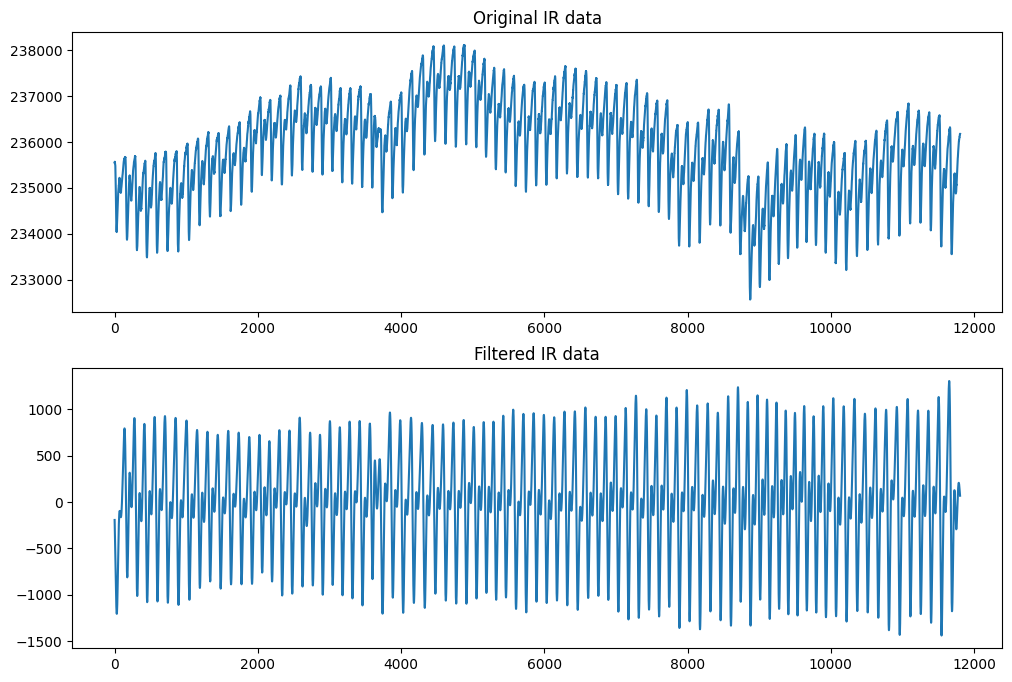

Results from turning original IR count signal of length 11806 into filtered IR count signal of 11806
This function does not add the filtered time signal into any dataset though, we'll probably work on that later
Time elapsed: 59.051000118255615 s


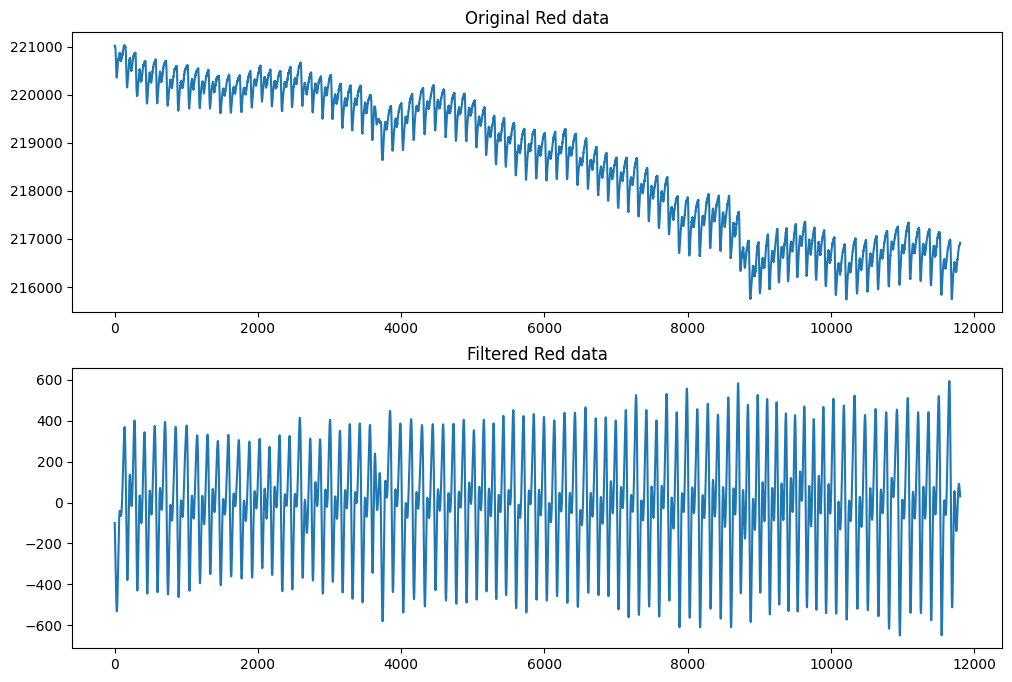

Results from turning original Red count signal of length 11806 into filtered IR count signal of 11806
This function does not add the filtered time signal into any dataset though, we'll probably work on that later


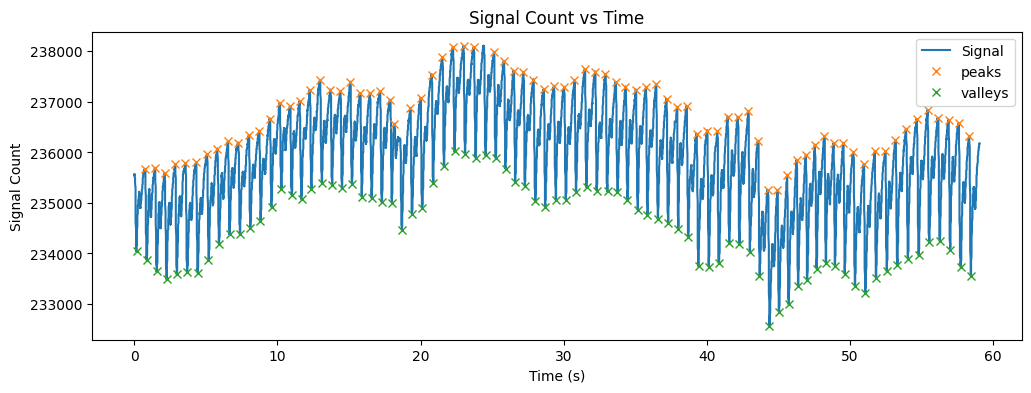

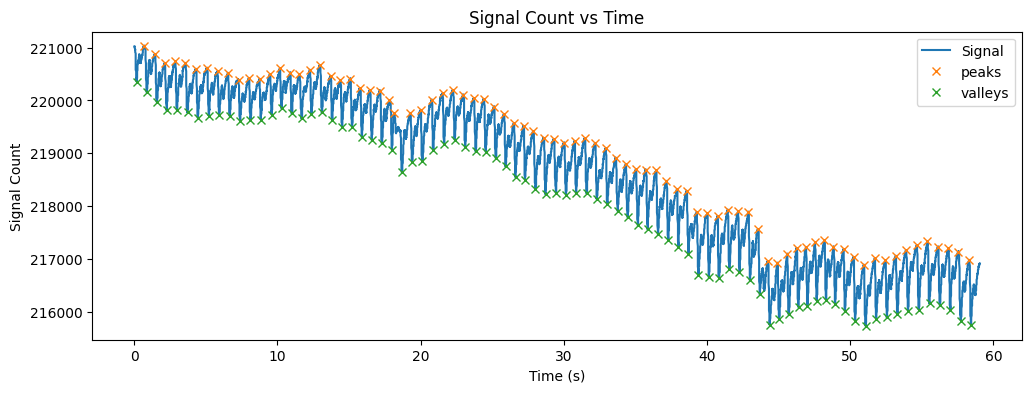

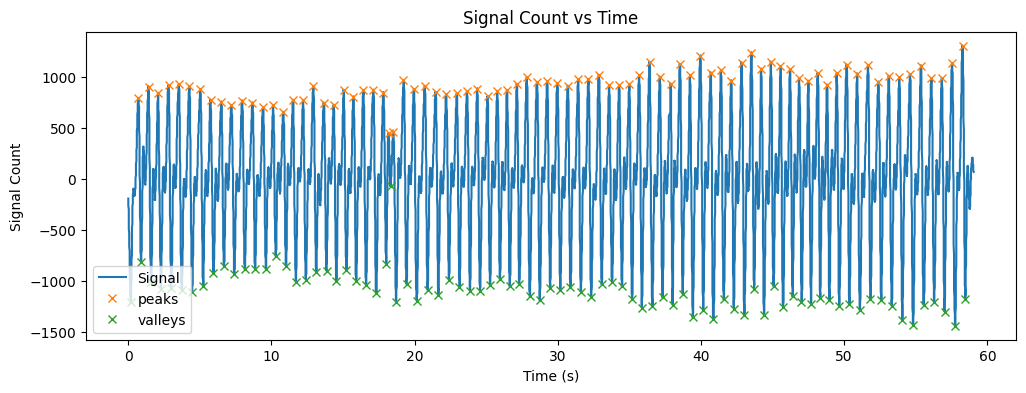

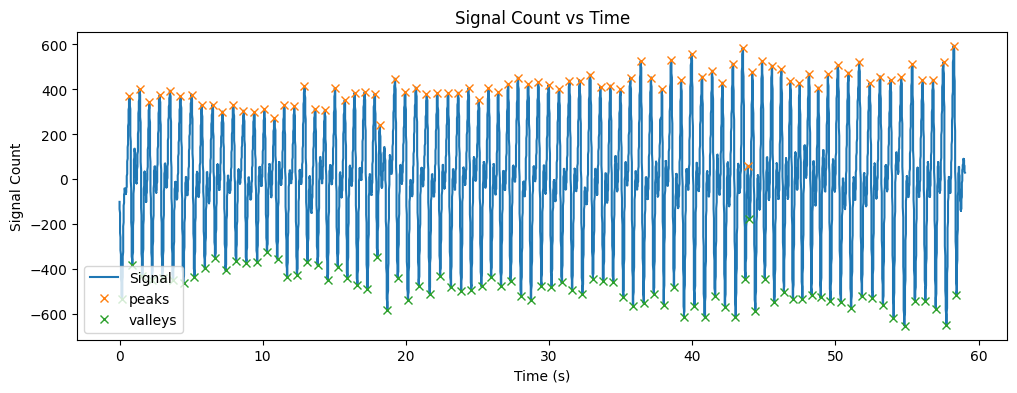

In [119]:
time = np.array([convert_to_sec(x) for x in df["Time"]]) - convert_to_sec(df["Time"][0])
IR_Count = df[" IR Count"]
Red_Count = df[" Red Count"]
smoothed_IR = smooth_data(df, 'IR')
smoothed_Red = smooth_data(df, 'Red')


peaks_ir, valleys_ir = peak_valley_finder_and_plot(IR_Count, time, prominence=PROMINENCE_IR)
peaks_red, valleys_red = peak_valley_finder_and_plot(Red_Count, time, prominence=PROMINENCE_RED)

peaks_ir_smoothed, valleys_ir_smoothed = peak_valley_finder_and_plot(smoothed_IR, time, prominence=500)
peaks_red_smoothed, valleys_red_smoothed = peak_valley_finder_and_plot(smoothed_Red, time, prominence=200)
# print(peaks)
# widths = peak_widths(IR_Count, peaks=peaks)
# print(widths)

In [120]:
### USING THE IR COUNT ###
peak_times_ir = list(set(np.round(time[peaks_ir], 3)))
peak_vals_ir = IR_Count[peaks_ir]

valley_times_ir = list(set(np.round(time[valleys_ir], 3)))
valley_vals_ir = IR_Count[valleys_ir]

diffs_peaks_ir = np.diff(peak_times_ir)
diffs_valleys_ir = np.diff(valley_times_ir)

#average over the whole timeframe
avg_bpm_peaks_ir = 60*(1/np.mean(diffs_peaks_ir))
avg_bpm_valleys_ir = 60*(1/np.mean(diffs_valleys_ir))

#moving average every 5 heartbeats
try:
    bpms_peaks_ir = [60*(1/np.mean(diffs_peaks_ir[i:i+5])) for i in range(len(diffs_peaks_ir) - 5)]
    bpms_valleys_ir = [60*(1/np.mean(diffs_valleys_ir[i:i+5])) for i in range(len(diffs_valleys_ir) - 5)]
except IndexError:
    sys.exit("Use more than 5 heartbeats for your data. Preferably way more!")
    
print("-------Based on IR Count-------")
print(f'Average BPM over time interval using peaks: {avg_bpm_peaks_ir:.2f}')
print(f'Average BPM over time interval using valleys: {avg_bpm_valleys_ir:.2f}')
print("BPM Moving Average with window length of 5 Heartbeats:")
print("Based on peaks: ",np.round(bpms_peaks_ir, 2))
print("Based on valleys: ", np.round(bpms_valleys_ir, 2))

### USING THE SMOOTHED IR COUNT ###
peak_times_ir_smoothed = list(set(np.round(time[peaks_ir_smoothed], 3)))
peak_vals_ir_smoothed = IR_Count[peaks_ir_smoothed]

valley_times_ir_smoothed = list(set(np.round(time[valleys_ir_smoothed], 3)))
valley_vals_ir_smoothed = IR_Count[valleys_ir]

diffs_peaks_ir_smoothed = np.diff(peak_times_ir_smoothed)
diffs_valleys_ir_smoothed = np.diff(valley_times_ir_smoothed)

#average over the whole timeframe
avg_bpm_peaks_ir_smoothed = 60*(1/np.mean(diffs_peaks_ir_smoothed))
avg_bpm_valleys_ir_smoothed = 60*(1/np.mean(diffs_valleys_ir_smoothed))

#moving average every 5 heartbeats
try:
    bpms_peaks_ir_smoothed = [60*(1/np.mean(diffs_peaks_ir_smoothed[i:i+5])) for i in range(len(diffs_peaks_ir_smoothed) - 5)]
    bpms_valleys_ir_smoothed = [60*(1/np.mean(diffs_valleys_ir_smoothed[i:i+5])) for i in range(len(diffs_valleys_ir_smoothed) - 5)]
except IndexError:
    sys.exit("Use more than 5 heartbeats for your data. Preferably way more!")

print()
print("-------Based on Smoothed IR Count-------")
print(f'Average BPM over time interval using peaks: {avg_bpm_peaks_ir_smoothed:.2f}')
print(f'Average BPM over time interval using valleys: {avg_bpm_valleys_ir_smoothed:.2f}')
print("BPM Moving Average with window length of 5 Heartbeats:")
print("Based on peaks: ",np.round(bpms_peaks_ir_smoothed, 2))
print("Based on valleys: ", np.round(bpms_valleys_ir_smoothed, 2))

-------Based on IR Count-------
Average BPM over time interval using peaks: 160.00
Average BPM over time interval using valleys: 164.00
BPM Moving Average with window length of 5 Heartbeats:
Based on peaks:  [ 84.2   82.83  82.08  81.34  81.37  81.37  82.01  81.37  83.5   82.58
  84.22  85.76  85.71  84.91  85.89  84.96  84.87  85.64  86.56  85.81
  97.94  85.79  85.01  82.69  82.01  73.24  80.6   80.69  69.06  69.59
  70.62  71.67  61.54  71.67  71.62  60.4   60.    59.63  59.99  46.83
  52.45  46.95  52.89  38.33  42.01  42.57  42.66  43.04  55.48  64.91
  56.82  48.98  48.5   53.36  46.6   50.79 137.3   81.32  80.65 101.08
 103.16 -14.27 -14.21 -14.19 -15.23 -16.38  38.32  46.71  42.2   42.77
  43.43  36.92  31.58  40.69 -17.6 ]
Based on valleys:  [ 84.2   82.78  82.08  81.32  81.28  82.03  82.71  81.99  82.83  83.03
  83.52  84.25  85.01  84.84  85.42  84.89  84.89  86.46  86.61  85.76
  86.56  85.76  85.01  83.4   82.78  81.3   80.67  80.67  81.43  82.69
  70.6   72.18  72.13  61.

In [121]:
### USING THE RED COUNT ###
peak_times_red = list(set(np.round(time[peaks_red], 3)))
peak_vals_red = Red_Count[peaks_red]

valley_times_red = list(set(np.round(time[valleys_red], 3)))
valley_vals_red = Red_Count[valleys_red]

diffs_peaks_red = np.diff(peak_times_red)
diffs_valleys_red = np.diff(valley_times_red)

#average over the whole timeframe
avg_bpm_peaks_red = 60*(1/np.mean(diffs_peaks_red))
avg_bpm_valleys_red = 60*(1/np.mean(diffs_valleys_red))

#moving average every 5 heartbeats
try:
    bpms_peaks_red = [60*(1/np.mean(diffs_peaks_red[i:i+5])) for i in range(len(diffs_peaks_red) - 5)]
    bpms_valleys_red = [60*(1/np.mean(diffs_valleys_red[i:i+5])) for i in range(len(diffs_valleys_red) - 5)]
except IndexError:
    sys.exit("Use more than 5 heartbeats for your data. Preferably way more!")
    
print("-------Based on Red Count-------")
print(f'Average BPM over time interval using peaks: {avg_bpm_peaks_red:.2f}')
print(f'Average BPM over time interval using valleys: {avg_bpm_valleys_red:.2f}')
print("BPM Moving Average with window length of 5 Heartbeats:")
print("Based on peaks: ",np.round(bpms_peaks_red, 2))
print("Based on valleys: ", np.round(bpms_valleys_red, 2))

### USING THE SMOOTHED RED COUNT ###
peak_times_red_smoothed = list(set(np.round(time[peaks_red_smoothed], 3)))
peak_vals_red_smoothed = Red_Count[peaks_red_smoothed]

valley_times_red_smoothed = list(set(np.round(time[valleys_red_smoothed], 3)))
valley_vals_red_smoothed = Red_Count[valleys_red_smoothed]

diffs_peaks_red_smoothed = np.diff(peak_times_red_smoothed)
diffs_valleys_red_smoothed = np.diff(valley_times_red_smoothed)

#average over the whole timeframe
avg_bpm_peaks_red_smoothed = 60*(1/np.mean(diffs_peaks_red_smoothed))
avg_bpm_valleys_red_smoothed = 60*(1/np.mean(diffs_valleys_red_smoothed))

#moving average every 5 heartbeats
try:
    bpms_peaks_red_smoothed = [60*(1/np.mean(diffs_peaks_red_smoothed[i:i+5])) for i in range(len(diffs_peaks_red_smoothed) - 5)]
    bpms_valleys_red_smoothed = [60*(1/np.mean(diffs_valleys_red_smoothed[i:i+5])) for i in range(len(diffs_valleys_red_smoothed) - 5)]
except IndexError:
    sys.exit("Use more than 5 heartbeats for your data. Preferably way more!")

print()
print("-------Based on Smoothed Red Count-------")
print(f'Average BPM over time interval using peaks: {avg_bpm_peaks_red_smoothed:.2f}')
print(f'Average BPM over time interval using valleys: {avg_bpm_valleys_red_smoothed:.2f}')
print("BPM Moving Average with window length of 5 Heartbeats:")
print("Based on peaks: ",np.round(bpms_peaks_red_smoothed, 2))
print("Based on valleys: ", np.round(bpms_valleys_red_smoothed, 2))

-------Based on Red Count-------
Average BPM over time interval using peaks: 165.79
Average BPM over time interval using valleys: 164.00
BPM Moving Average with window length of 5 Heartbeats:
Based on peaks:  [ 82.03  81.39  82.08  80.73  81.37  82.01  82.06  81.99  83.24  84.96
  85.76  85.71  85.01  85.89  84.22  85.62  85.64  87.29  87.31  97.94
  85.03  85.01  82.69  80.69  73.24  81.34  80.69  82.78  83.45  70.62
  71.09  61.54  61.51  61.16  60.4   60.    59.63  59.25  46.83  52.72
  46.95  53.17  38.33  42.01  42.39  42.66  42.85  55.81  64.91  56.48
  48.98  48.5   53.36  46.6   69.01  82.15  81.32  81.32 103.16  68.1
 -10.15 -12.93 -13.74 -13.74 -14.71  21.17  38.47  46.71  41.84  42.77
  43.43  37.05  31.58  40.84  -6.78 -15.75]
Based on valleys:  [ 84.2   81.94  81.34  81.32  81.97  82.03  82.83  81.99  82.83  83.03
  83.52  85.01  85.79  84.84  85.42  84.89  85.71  85.67  86.61  85.76
  86.56  84.94  85.01  83.4   82.78  81.3   80.67  80.67  82.1   82.69
  70.6   72.18  72.

In [122]:
avg_red_peak, avg_red_val, avg_ir_peak, avg_ir_val, avg_R, avg_SpO2 = avg_peak_and_trough_vals(Red_Count, IR_Count, peaks_red, valleys_red, peaks_ir, peaks_red)
print(f"Average Peak Value for Red Channel: {avg_red_peak:.2f} [counts]")
print(f"Average Peak Value for IR Channel: {avg_ir_peak:.2f} [counts]")
print(f"Average Trough Value for Red Channel: {avg_red_val:.2f} [counts]")
print(f"Average Trough Value for IR Channel: {avg_ir_val:.2f} [counts]")
print(f"Average Ratio of Ratios: {avg_R:.2f}")
print(f"Average SpO2: {avg_SpO2:.2f}%")

Average Peak Value for Red Channel: 219010.60 [counts]
Average Peak Value for IR Channel: 236753.40 [counts]
Average Trough Value for Red Channel: 218013.28 [counts]
Average Trough Value for IR Channel: 236758.85 [counts]
Average Ratio of Ratios: -198.42
Average SpO2: -657702.84%
